In [1]:
%load_ext autoreload
%autoreload 2
import torch
import networkx as nx
import matplotlib.pyplot as plt
import copy
import numpy as np

import sys
sys.path.insert(0, "../models/")
sys.path.insert(0, "../lidar/")
from relu_nn import FFReLUNet, FFTanhNet, FFSigmoidNet
from lidar import RandomPoseLidarDataset

torch.set_default_tensor_type(torch.DoubleTensor)

In [2]:
class SIRENLayer(torch.nn.Module):
    def __init__(self, in_features, out_features, scale=0.01):
        super().__init__()
        self.out_features = out_features
        self.in_features = in_features
        self.linear = torch.nn.Linear(in_features, out_features)
        self.scale = scale
        self.init_weights()

    def init_weights(self):
        c = np.sqrt(6 / self.out_features)
        with torch.no_grad():
            self.linear.weight.uniform_(-c, c)
    
    def forward(self, x):
        x = self.linear(x)
        return torch.sin(self.scale * x)

class FourierNet(torch.nn.Module):
    def __init__(self, shape):
        super().__init__()

        c = np.sqrt(6 / shape[1])
        B = torch.FloatTensor(shape[0], shape[1]).uniform_(-c, c)

        layers = []

        for i in range(len(shape) - 1):
            if i == 0:
                layers.append(SIRENLayer(shape[0], shape[1]))
            else:
                layers.append(torch.nn.Linear(shape[i], shape[i + 1]))
            
            if i != len(shape) - 2:
                layers.append(torch.nn.ReLU(inplace=True))
            else:
                layers.append(torch.nn.Sigmoid())
        
        self.seq = torch.nn.Sequential(*layers)
    
    def forward(self, x):
        return self.seq(x)


In [3]:
# Setup data
num_beams = 20
beam_samps = 20
scan_dist = 0.2
num_scans = 6000
img_dir = "../floorplans/32_b.png"

train_set = RandomPoseLidarDataset(img_dir, num_beams, scan_dist, beam_samps, num_scans)
val_set = RandomPoseLidarDataset(img_dir, num_beams, scan_dist, beam_samps, 300)

In [4]:
len(train_set)

1444659

In [5]:
def validate(base_loss, val_loader, model):
    with torch.no_grad():
        val_loss = 0.0
        for batch in val_loader:
            yh = model.forward(batch["position"])
            val_loss += base_loss(yh, batch["density"]).data.detach()
        return val_loss


In [7]:
bs = 10000 # number of forward passes per gradient compute
train_loader = torch.utils.data.DataLoader(train_set, batch_size=bs)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=bs)

shape = [2, 86, 32, 32, 32, 1]
model = FourierNet(shape)

loss = torch.nn.BCELoss()

lr = 0.005
epochs = 3

opt = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    # Check Validation loss
    val_loss = 0.0
    for i, batch in enumerate(val_loader):
        with torch.no_grad():
            pd = model.forward(batch["position"])
            l = loss(pd, batch["density"])
            val_loss += l.data.detach()
    print(val_loss)

    # Training step
    for i, batch in enumerate(train_loader):
        opt.zero_grad()
        poses = batch["position"]
        dens = batch["density"]

        pred_dens = model.forward(poses)
        l = loss(pred_dens, dens)
        l.backward()
        opt.step()

tensor(5.2172)
tensor(1.6369)
tensor(1.2694)


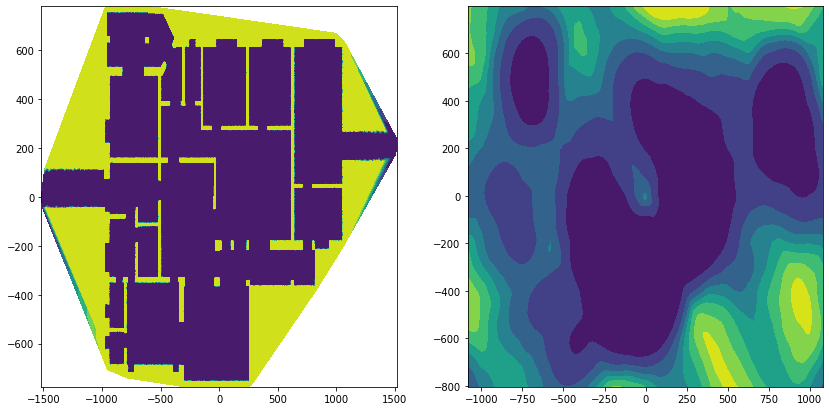

In [16]:
fig, (ax0, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(14, 7))
X, Y = np.meshgrid(train_set.lidar.xs, train_set.lidar.ys)
xlocs = X[::8, ::8].reshape(-1, 1)
ylocs = Y[::8, ::8].reshape(-1, 1)
val_poses = np.hstack((xlocs, ylocs))

val_inputs = torch.Tensor(val_poses)

with torch.no_grad():
    pred_dens = model.forward(val_inputs)

ax0.tricontourf(train_set.scans[:, 0],train_set.scans[:, 1],train_set.scans[:, 2])
ax1.tricontourf(xlocs.flatten(), ylocs.flatten(), pred_dens.numpy().flatten())

In [110]:
torch.amax(pred_dens)

tensor(0.9989)